In [1]:
# event_time: timestamp when the event occurred.
# event_type: type of event.
# product_id: ID of the product related to the event.
# category_id: ID of the category to which the product belongs.
# category_code: category code of the product.
# brand: brand of the product.
# price: price of the product.
# user_id: ID of the user related to the event.
# user_session: session of the user in which the event occurred.

In [ ]:
"""

- Exploración de datos:

  - Limpieza de datos nulos en el dataset
  - Explicar los distintos datos y sus valores
  - Estudio de las fechas (festivas, histograma de cantidad)
  - Estudiar la distribución de precios con un grafico de caja
  - Estudiar el evento más frecuente asociado a un precio


"""

In [ ]:
!pip install pyspark
!pip install findspark
!pip install jvm
!pip install holidays

In [153]:
import findspark
import os

import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, approx_count_distinct, when, expr

In [109]:
# Initializing findspark
findspark.init()
#findspark.find()

# Establishing connection with python
os.environ['PYSPARK_PYTHON'] = 'python'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'

# Initializing spark
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "15g").appName('E-Commerce').getOrCreate()

# Setting timezone as UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")

# Reading files & inferring the data types
oct_2019 = spark.read.csv("../input/2019-Oct.csv", header=True, inferSchema=True)
nov_2019 = spark.read.csv("../input/2019-Nov.csv", header=True, inferSchema=True)
dec_2019 = spark.read.csv("../input/2019-Dec.csv", header=True, inferSchema=True)
jan_2020 = spark.read.csv("../input/2020-Jan.csv", header=True, inferSchema=True)
feb_2020 = spark.read.csv("../input/2020-Feb.csv", header=True, inferSchema=True)

# Merging dataframes into a single one
raw_data = oct_2019.union(nov_2019).union(dec_2019).union(jan_2020).union(feb_2020)

# Showing data types inferred
raw_data.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [110]:
# Showing dataset
raw_data.show()

+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|      event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:00|            cart|   5773203|1487580005134238553|         null|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:03|            cart|   5773353|1487580005134238553|         null|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:07|            cart|   5881589|2151191071051219817|         null|  lovely|13.48|429681830|49e8d843-adf3-428...|
|2019-10-01 00:00:07|            cart|   5723490|1487580005134238553|         null|  runail| 2.62|463240011|26dd6e6e-4dac-477...|
|2019-10-01 00:00:15|            cart|   5881449|1487580013522845895|         null|  lovel

In [115]:
# Counting rows
raw_data.count()

20692840

In [114]:
# Filtering records to drop non-positive prices
non_positive = raw_data.filter(col("price") <= 0)
df = raw_data.filter(col("price") > 0)

# Counting non-positive prices
count_non_positives = non_positive.count()

# Showing non-positive prices
non_positive.show()

# Printing the count of negative prices
print("Number of non-positive prices:", count_non_positives, "\n")

+-------------------+----------+----------+-------------------+-------------+-----+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+-----+-----+---------+--------------------+
|2019-10-01 02:05:17|      view|   5892084|1597770225539875791|         null| null|  0.0|555458569|c048be2f-547d-4ad...|
|2019-10-01 02:15:41|      view|   5892052|1487580010377117763|         null| null|  0.0|555455025|320f6021-30ac-4a5...|
|2019-10-01 04:25:00|      view|   5873432|2007399943458784057|apparel.glove| null|  0.0|500054739|701220b4-45b4-402...|
|2019-10-01 04:33:15|      view|   5882605|1487580013522845895|         null| null|  0.0|523154930|caaf1f68-7b97-4d2...|
|2019-10-01 05:16:30|      view|   5889621|1487580010561667147|         null| null|  0.0|523988665|00849bd2-fcd2-4cb...|
|2019-10-01 05:18:03|      view|

In [112]:
# Counting null values per column
null_counts = df.select([count(when(col(column).isNull(), column)).alias(column) for column in df.columns])

# Showing dataframe
null_counts.show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     20236422|8652850|    0|      0|        4597|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [113]:
# Counting unique values per column
unique_counts = df.select([approx_count_distinct(col(column)).alias(column) for column in df.columns])

# Showing dataframe
unique_counts.show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|   9454101|         4|     53324|        500|           12|  293| 2747|1629062|     4817636|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



In [116]:
# Defining auxiliar function for counting unique values
unique_count_rows = lambda dataframe, column_name: dataframe.groupBy(column_name).agg(count("*").alias("count"))

# Selecting columns to apply unique count function
column_names = ["event_time", "event_type", "brand", "price"]

"Applying function to every column in column names"

# Initializing dictionary for counting values
value_counts_by_column = {}

for column in column_names:

    # Counting unique rows per each column
    unique_counts = unique_count_rows(df, column)

    # Converting to a list of tuples
    unique_counts_list = [(row[column], row["count"]) for row in unique_counts.collect()]

    # Adding the result to the dictionary
    value_counts_by_column[column] = unique_counts_list

# Printing keys for accessing the counts
value_counts_by_column.keys()

dict_keys(['event_time', 'event_type', 'brand', 'price'])

In [117]:
# Extracting counts for each event types
value_counts_by_column["event_type"]

[('purchase', 1286880),
 ('view', 9627329),
 ('cart', 5718963),
 ('remove_from_cart', 3955380)]

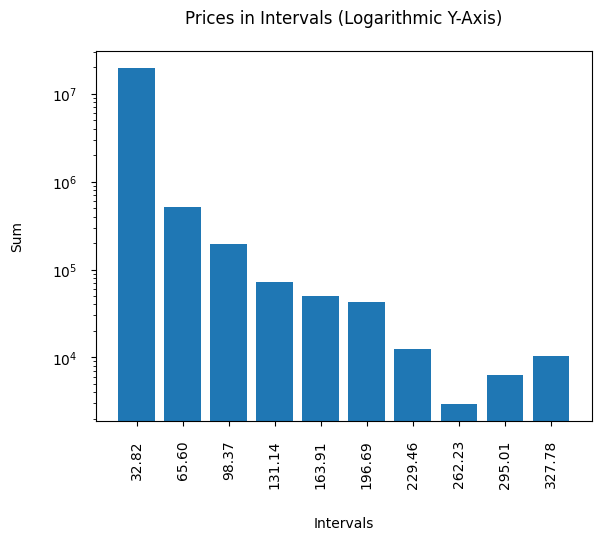

In [138]:
# Extracting prices and counts for each product
price, count = zip(*value_counts_by_column["price"])

# Setting number how many intervals are plotted
n_labels = 10
intervals = np.linspace(min(price), max(price), n_labels + 1)

# Initializing sum intervals for plotting
sums_in_intervals = []

for i in range(n_labels):
    # Calculating the sum of count values within each interval
    sum_within_interval = sum(val[1] for val in value_counts_by_column["price"] if intervals[i] <= val[0] < intervals[i+1])
    # Appending values into y-axis
    sums_in_intervals.append(sum_within_interval)

# Creating subplots
fig, ax = plt.subplots()

# Plotting prices & counts
ax.bar(range(n_labels), sums_in_intervals)

# Setting ticks for x-axis
ax.set_xticks(range(n_labels))
ax.set_xticklabels(['{:.2f}'.format(intervals[i+1]) for i in range(n_labels)], rotation='vertical')

# Setting labels for x-axis & y-axis
ax.set_xlabel('Intervals', labelpad=20)
ax.set_ylabel('Sum', labelpad=20)

# Setting scale for y-axis
ax.set_yscale('log')

# Setting title
ax.set_title('Prices in Intervals (Logarithmic Y-Axis)', pad=20)

# Adjusting spaces between labels and ticks in both x-axis and y-axis
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

# Displaying the plot
plt.show()

In [154]:
# Calculating price intervals
interval = (df.selectExpr("percentile_approx(price, 0.1)").first()[0],
            df.selectExpr("percentile_approx(price, 0.2)").first()[0],
            df.selectExpr("percentile_approx(price, 0.3)").first()[0],
            df.selectExpr("percentile_approx(price, 0.4)").first()[0],
            df.selectExpr("percentile_approx(price, 0.5)").first()[0],
            df.selectExpr("percentile_approx(price, 0.6)").first()[0],
            df.selectExpr("percentile_approx(price, 0.7)").first()[0],
            df.selectExpr("percentile_approx(price, 0.8)").first()[0],
            df.selectExpr("percentile_approx(price, 0.9)").first()[0],
            df.selectExpr("percentile_approx(price, 1)").first()[0])

# Adding a "price_interval" column for indicating the interval to which the price belongs
df_with_interval = df.withColumn("price_interval",
                                 expr("CASE WHEN price <= {} THEN 'Intervalo 1' " \
                                      "WHEN price <= {} THEN 'Intervalo 2' " \
                                      "WHEN price <= {} THEN 'Intervalo 3' " \
                                      "WHEN price <= {} THEN 'Intervalo 4' " \
                                      "WHEN price <= {} THEN 'Intervalo 5' " \
                                      "WHEN price <= {} THEN 'Intervalo 6' " \
                                      "WHEN price <= {} THEN 'Intervalo 7' " \
                                      "WHEN price <= {} THEN 'Intervalo 8' " \
                                      "WHEN price <= {} THEN 'Intervalo 9' " \
                                      "ELSE 'Intervalo 10' END".format(*interval)))

# Calculating the most frequent events per interval
frequent_events = df_with_interval.groupBy("price_interval", "event_type").count().orderBy("price_interval", col("count").desc())

# Showing results
frequent_events.show()

+--------------+----------------+-------+
|price_interval|      event_type|  count|
+--------------+----------------+-------+
|   Intervalo 1|            cart| 917306|
|   Intervalo 1|            view| 574762|
|   Intervalo 1|remove_from_cart| 446535|
|   Intervalo 1|        purchase| 202639|
|  Intervalo 10|            view|1574344|
|  Intervalo 10|            cart| 262403|
|  Intervalo 10|remove_from_cart| 166651|
|  Intervalo 10|        purchase|  54870|
|   Intervalo 2|            cart| 718237|
|   Intervalo 2|            view| 713458|
|   Intervalo 2|remove_from_cart| 502525|
|   Intervalo 2|        purchase| 178135|
|   Intervalo 3|            view| 730648|
|   Intervalo 3|            cart| 653241|
|   Intervalo 3|remove_from_cart| 479600|
|   Intervalo 3|        purchase| 154566|
|   Intervalo 4|            view| 820859|
|   Intervalo 4|            cart| 577689|
|   Intervalo 4|remove_from_cart| 450819|
|   Intervalo 4|        purchase| 126278|
+--------------+----------------+-